# Graph Traversal - Breadth First Search (BFS) Algorithm

In this notebook, we'll implement the Breadth First Search (BFS) algorithm for graph traversal. Although BFS can be applied to undirected & directed graphs, in the example worked below we will use a directed graph.

There are various applications for the BFS algorithm, some examples of which include:
* finding paths between nodes in a graph
* identifying connections between components in a graph
* calculating max-flow between sets of source and target nodes
* solving shortest path problems

The algorithm was first published in 1959 by Edward F. Moore: "The shortest path through a maze". Proceedings of the International Symposium on the Theory of Switching. Harvard University Press. pp. 285–292.

In [1]:
from typing import List
import sknetwork as skn
import numpy as np
from IPython.display import SVG

And now we can run the notebook from the PageRank post to load in the objects implemented there:

In [2]:
%run Notebook\ XXIX\ Learn\ the\ PageRank\ Algorithm\ with\ 1\ Simple\ Example.ipynb

In [3]:
# view the edges imported from the XXIX notebook
edges

[('A', 'B'),
 ('B', 'D'),
 ('D', 'A'),
 ('D', 'C'),
 ('A', 'C'),
 ('C', 'A'),
 ('D', 'E'),
 ('F', 'D')]

In [4]:
graph = skn.data.from_edge_list(edges, directed=True)

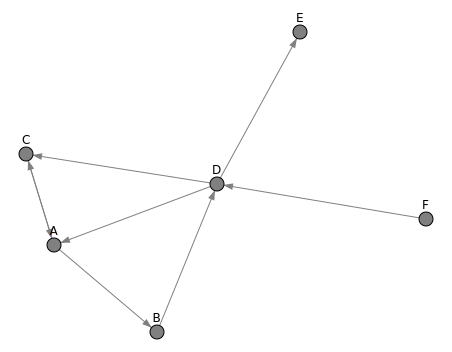

In [5]:
image = skn.visualization.graphs.visualize_graph(adjacency=graph.adjacency, names=graph.names, name_position='above')
SVG(image)

## The Algorithm

The BFS algorithm is a technique for traversing a graph, given a starting node from which to begin. The general strategy is to explore all possible neighbouring nodes that are the same number of "hops", or edges, away from the starting node before looking at nodes that are more distant.

One consideration we need to keep in mind is the presence of cycles in the graph: this could lead to an infinite traversal if not accounted for. As such, we know right away that we will need to keep track of the nodes already visited while passing through the graph. 

BFS is executed in the following fashion:
* Initialize by creating a **queue** object $q$ and enter the starting node $s$ into this queue. Also mark all nodes in the graph as "not visited"
* While $q$ is not empty:
    * Pop a node $n$ from $q$, and perform whatever calculations are needed at that node
    * For each unvisited neighbour of $n$:
        * Add the neighbour into $q$
        * Mark the neighbour as visited

## Implementation

Let's implement a BFS class to encapsulate the algorithm defined above:

In [6]:
class BFS(object):

    def __init__(self, graph: Graph) -> None:
        self.graph = graph

    def _prepare_for_traversal(self, source: str) -> None:
        self.queue = [source]
        self.visited = dict(zip(self.graph.nodes, len(self.graph.nodes) * [False]))
        self.visited[source] = True

    def _computations_on_node(self, node: str) -> None:
        print(f"Processing node {node}")

    def _process_unvisited_neighbours(self, node: str) -> None:
        node_index = self.graph.nodes.index(node)
        neighbours_indices = self.graph.get_modified_adjacency_matrix()[:,node_index].nonzero()[0].tolist()
        neighbours = np.array(self.graph.nodes)[neighbours_indices].tolist()
        for neighbour in neighbours:
            if not self.visited[neighbour]:
                self.queue.append(neighbour)
                self.visited[neighbour] = True
    
    def traverse(self, source: str) -> None:
        # prepare for the traversal
        self._prepare_for_traversal(source)
        # process queue
        while self.queue:
            # pop a node from the queue, and perform desired actions on the node
            node = self.queue.pop(0)
            self._computations_on_node(node)
            # go to each unvisited neighbour of node
            self._process_unvisited_neighbours(node)

In [7]:
# create a graph instance
graph = Graph(edges)

In [8]:
# create a BFS instance
bfs = BFS(graph)

We can experiement with a few different source node choices:

In [9]:
bfs.traverse('A')

Processing node A
Processing node B
Processing node C
Processing node D
Processing node E


In [10]:
bfs.traverse('D')

Processing node D
Processing node A
Processing node C
Processing node E
Processing node B


In [11]:
bfs.traverse('F')

Processing node F
Processing node D
Processing node A
Processing node C
Processing node E
Processing node B


Node F only appears in our results when it is set as a source node. This makes sense as we are working with a directed graph, and F has no incoming edges.

To make this a bit more tangeable, let's see if we can extend BFS to map out the shortest path between 2 nodes:

In [12]:
class Path(object):

    def __init__(self, label: str):
        self.label = label
        self.next_level = []

class PathFinder(BFS):
    
    def _add_to_paths(self, paths: Path, node: str, neighbour: str) -> None:
        if paths.label == node:
            paths.next_level.append(Path(neighbour))
        elif (paths.label != node) and paths.next_level:
            for path in paths.next_level:
                self._add_to_paths(path, node, neighbour)    
    
    def _process_unvisited_neighbours(self, node: str) -> None:
        node_index = self.graph.nodes.index(node)
        neighbours_indices = self.graph.get_modified_adjacency_matrix()[:,node_index].nonzero()[0].tolist()
        neighbours = np.array(self.graph.nodes)[neighbours_indices].tolist()
        for neighbour in neighbours:
            if not self.visited[neighbour]:
                self.queue.append(neighbour)
                self.visited[neighbour] = True
                self._add_to_paths(self.paths, node, neighbour)

    def _determine_shortest_path(self, paths: Path, target: str, path_string: str) -> None:
        if paths.label == target:
            self.shortest_path = path_string + target
        elif paths.next_level:
            for path in paths.next_level:
                self._determine_shortest_path(path, target, path_string + paths.label)
    
    def find_shortest_path(self, source: str, target: str) -> str:
        # initialize path string
        self.shortest_path = ""
        # define a Path instance to store all possible paths from source
        self.paths = Path(source)
        # traverse graph
        self.traverse(source)
        # identify shortest path that terminates at target
        self._determine_shortest_path(self.paths, target, self.shortest_path)
        # return shortest path
        return self.shortest_path

In [13]:
# create a PathFinder instance
pf = PathFinder(graph)

Let's experiment with a few different node pairs:

In [14]:
pf.find_shortest_path('F','E')

Processing node F
Processing node D
Processing node A
Processing node C
Processing node E
Processing node B


'FDE'

In [15]:
pf.find_shortest_path('A','F')

Processing node A
Processing node B
Processing node C
Processing node D
Processing node E


''

In [16]:
pf.find_shortest_path('A','E')

Processing node A
Processing node B
Processing node C
Processing node D
Processing node E


'ABDE'

It is apparent that our new class **PathFinder** is able to map out the shortest path between two nodes in our directed graph, if such a path exists.